In [390]:
import pandas as pd
import numpy as np
import seaborn as sns
import missingno as msno
from sklearn import metrics
from xgboost import XGBClassifier, XGBRegressor
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from keras.api.models import Sequential
from keras.api.layers import Input, LSTM, Dense

In [391]:
df1 = pd.read_csv("Downloads/power_consumption_g3.csv")
df2 = pd.read_csv("Downloads/power_consumption_g3_feat.csv")

In [392]:
merged = pd.merge(df1,df2,on="Date")

In [393]:
merged.sample(5)

,Date,SolarPower,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows
16810,2017-02-27 22:50:00,35774.23729,13.81,67.39,0.085,0.048,0.096
29578,2017-07-17 01:30:00,31581.12957,25.29,85.50,4.924,0.069,0.137
2567,2017-03-11 03:20:00,23101.27660,12.51,70.90,4.919,0.015,0.089
43416,2017-10-04 01:20:00,27671.94748,25.02,39.05,4.922,0.095,0.059
1219,2017-07-16 04:10:00,30088.50498,25.51,87.00,4.917,0.040,0.159


In [394]:
merged['Date'] = pd.to_datetime(merged['Date'])
merged.set_index(keys=['Date'], inplace=True)
merged.sort_index(inplace=True)

In [395]:
merged.isnull().sum()

SolarPower               0
Temperature            559
Humidity               499
WindSpeed              529
GeneralDiffuseFlows    524
DiffuseFlows           505
dtype: int64

In [396]:
features=["Temperature", "Humidity", "WindSpeed", "GeneralDiffuseFlows", "DiffuseFlows"]
target = 'SolarPower'

In [397]:
for feature in features:
    merged[feature] = merged[feature].interpolate(method='linear')

In [398]:
#se potpolnuvaat null vred so linearna interpolacija, linearni vrednosti

In [399]:
merged = merged.groupby(pd.Grouper(freq="2h")).mean()

<Axes: xlabel='Date', ylabel='Temperature'>

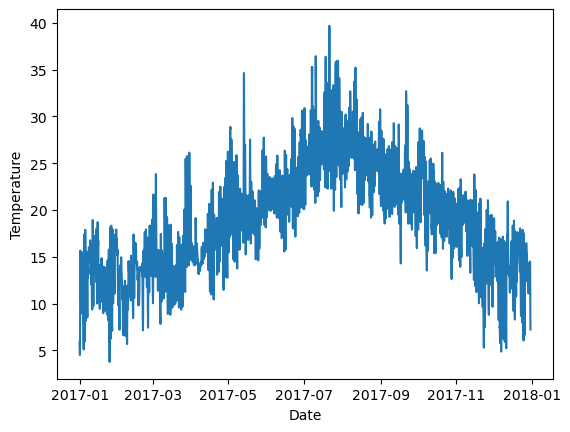

In [400]:
sns.lineplot(merged['Temperature'])

In [402]:
lags = range(4, 0, -1)
list(lags)

[4, 3, 2, 1]

In [403]:
for lag in lags:
    for column in features + [target]:
        merged[f"{column}_{lag}"] = merged[column].shift(lag)
merged

,SolarPower,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,Temperature_4,Humidity_4,WindSpeed_4,GeneralDiffuseFlows_4,...,WindSpeed_2,GeneralDiffuseFlows_2,DiffuseFlows_2,SolarPower_2,Temperature_1,Humidity_1,WindSpeed_1,GeneralDiffuseFlows_1,DiffuseFlows_1,SolarPower_1
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,26927.594937,5.866833,76.300000,0.081917,0.060167,0.105667,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01 02:00:00,21447.088607,5.029333,78.008333,0.082583,0.061417,0.135083,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,5.866833,76.300000,0.081917,0.060167,0.105667,26927.594937
2017-01-01 04:00:00,20641.518987,4.919667,74.641667,0.081667,0.061917,0.120833,NaN,NaN,NaN,NaN,...,0.081917,0.060167,0.105667,26927.594937,5.029333,78.008333,0.082583,0.061417,0.135083,21447.088607
2017-01-01 06:00:00,20094.683545,4.512750,74.575000,0.082417,0.063583,0.122500,NaN,NaN,NaN,NaN,...,0.082583,0.061417,0.135083,21447.088607,4.919667,74.641667,0.081667,0.061917,0.120833,20641.518987
2017-01-01 08:00:00,21255.189872,4.632167,73.791667,0.082417,79.281917,15.761833,5.866833,76.300000,0.081917,0.060167,...,0.081667,0.061917,0.120833,20641.518987,4.512750,74.575000,0.082417,0.063583,0.122500,20094.683545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-30 14:00:00,29293.789606,14.513333,39.675417,0.077667,409.650000,42.163333,11.221667,48.974583,0.078417,0.062917,...,0.077000,353.441667,36.275833,29649.683142,14.399167,38.129167,0.077667,489.841667,38.455000,30490.240812
2017-12-30 16:00:00,31262.864386,14.015000,43.082500,0.077500,153.905000,152.368333,11.082500,48.224167,0.078083,76.933417,...,0.077667,489.841667,38.455000,30490.240812,14.513333,39.675417,0.077667,409.650000,42.163333,29293.789606
2017-12-30 18:00:00,37721.673005,10.112500,60.359583,0.075583,1.618917,1.676750,13.382500,43.325000,0.077000,353.441667,...,0.077667,409.650000,42.163333,29293.789606,14.015000,43.082500,0.077500,153.905000,152.368333,31262.864386


In [404]:
merged.drop(columns=features, inplace=True)

In [405]:
merged.dropna(axis=0, inplace=True)

In [406]:
merged.isnull().sum()

SolarPower               0
Temperature_4            0
Humidity_4               0
WindSpeed_4              0
GeneralDiffuseFlows_4    0
DiffuseFlows_4           0
SolarPower_4             0
Temperature_3            0
Humidity_3               0
WindSpeed_3              0
GeneralDiffuseFlows_3    0
DiffuseFlows_3           0
SolarPower_3             0
Temperature_2            0
Humidity_2               0
WindSpeed_2              0
GeneralDiffuseFlows_2    0
DiffuseFlows_2           0
SolarPower_2             0
Temperature_1            0
Humidity_1               0
WindSpeed_1              0
GeneralDiffuseFlows_1    0
DiffuseFlows_1           0
SolarPower_1             0
dtype: int64

In [407]:
X, y = merged.drop(columns=[target]), merged[target]
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.20, shuffle=False)

In [409]:
scaler = MinMaxScaler()
train_X = scaler.fit_transform(train_X)
test_X = scaler.transform(test_X)

In [411]:
lag = 4
(train_X.shape[0], lag, (train_X.shape[1] // lag))

(3491, 4, 6)

XGBoost Regressor

In [414]:
regressor = XGBRegressor(n_estimators=30).fit(train_X, train_y)

In [415]:
pred_y = regressor.predict(test_X)

In [416]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
(mean_absolute_error(test_y, pred_y), mean_squared_error(test_y, pred_y), r2_score(test_y, pred_y))

(1378.9127763254105, 3433557.168053115, 0.9039969383913953)

Neural Network

In [418]:
train_y = scaler.fit_transform(train_y.to_numpy().reshape(-1, 1))

In [419]:
lag = 4
(train_X.shape[0], lag, (train_X.shape[1] // lag))

(3491, 4, 6)

In [420]:
train_X = train_X.reshape((train_X.shape[0], lag, (train_X.shape[1] // lag)))
test_X = test_X.reshape((test_X.shape[0], lag, (test_X.shape[1] // lag)))

In [421]:
model = Sequential([
    Input((train_X.shape[1], train_X.shape[2],)),
    LSTM(64, activation="relu", return_sequences=True),
    LSTM(32, activation="relu"),
    Dense(1, activation="linear")
])

In [423]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                        │ (None, 4, 64)               │          18,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,625 (119.63 KB)

 Trainable params: 30,625 (119.63 KB)

 Non-trainable params: 0 (0.00 B)

In [424]:
model.compile(
    loss="mean_squared_error",
    optimizer="adam",
    metrics=["mean_squared_error"],
)

In [425]:
history = model.fit(train_X, train_y, validation_split=0.20, epochs=20, batch_size=64, shuffle=False)

Epoch 1/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.1710 - mean_squared_error: 0.1710 - val_loss: 0.0274 - val_mean_squared_error: 0.0274
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0275 - mean_squared_error: 0.0275 - val_loss: 0.0183 - val_mean_squared_error: 0.0183
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0211 - mean_squared_error: 0.0211 - val_loss: 0.0167 - val_mean_squared_error: 0.0167
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0203 - mean_squared_error: 0.0203 - val_loss: 0.0157 - val_mean_squared_error: 0.0157
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0193 - mean_squared_error: 0.0193 - val_loss: 0.0147 - val_mean_squared_error: 0.0147
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0183 - mean_squared_error: 0.0183 - val_loss: 0.0138 - val_mean_squared_error: 0.0138
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0169 - mean_squared_error: 0.0169 - val_loss: 0.0131 - val_mea

<Axes: >

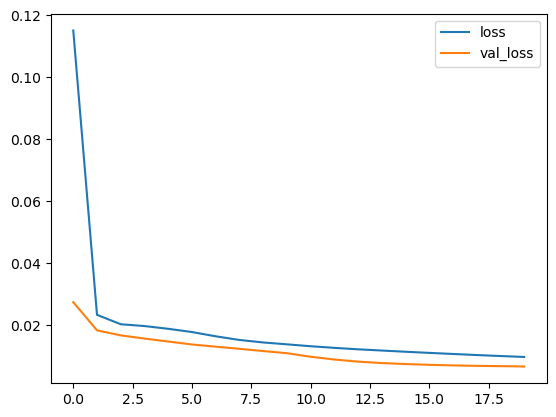

In [426]:
sns.lineplot(history.history["loss"], label="loss")
sns.lineplot(history.history["val_loss"], label="val_loss")

In [427]:
pred_y = model.predict(test_X)

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


In [428]:
pred_y = scaler.inverse_transform(pred_y)

In [429]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
(mean_absolute_error(test_y, pred_y), mean_squared_error(test_y, pred_y), r2_score(test_y, pred_y))

(2887.987641036417, 12712715.642272923, 0.6445494968386325)